In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

In [25]:
images = []
labels = []
for subfolder in tqdm(os.listdir('C:/Users/khush/Documents/Khushi/5th_Sem/SolutionsChallengeOther/Alzheimers_dataset')):
    subfolder_path = os.path.join('C:/Users/khush/Documents/Khushi/5th_Sem/SolutionsChallengeOther/Alzheimers_dataset', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]


image           label
0     C:/Users/khush/Documents/Khushi/5th_Sem/Soluti...   Final AD JPEG
1     C:/Users/khush/Documents/Khushi/5th_Sem/Soluti...   Final AD JPEG
2     C:/Users/khush/Documents/Khushi/5th_Sem/Soluti...   Final AD JPEG
3     C:/Users/khush/Documents/Khushi/5th_Sem/Soluti...   Final AD JPEG
4     C:/Users/khush/Documents/Khushi/5th_Sem/Soluti...   Final AD JPEG
...                                                 ...             ...
7836  C:/Users/khush/Documents/Khushi/5th_Sem/Soluti...  Final MCI JPEG
7837  C:/Users/khush/Documents/Khushi/5th_Sem/Soluti...  Final MCI JPEG
7838  C:/Users/khush/Documents/Khushi/5th_Sem/Soluti...  Final MCI JPEG
7839  C:/Users/khush/Documents/Khushi/5th_Sem/Soluti...  Final MCI JPEG
7840  C:/Users/khush/Documents/Khushi/5th_Sem/Soluti...  Final MCI JPEG

[7841 rows x 2 columns]

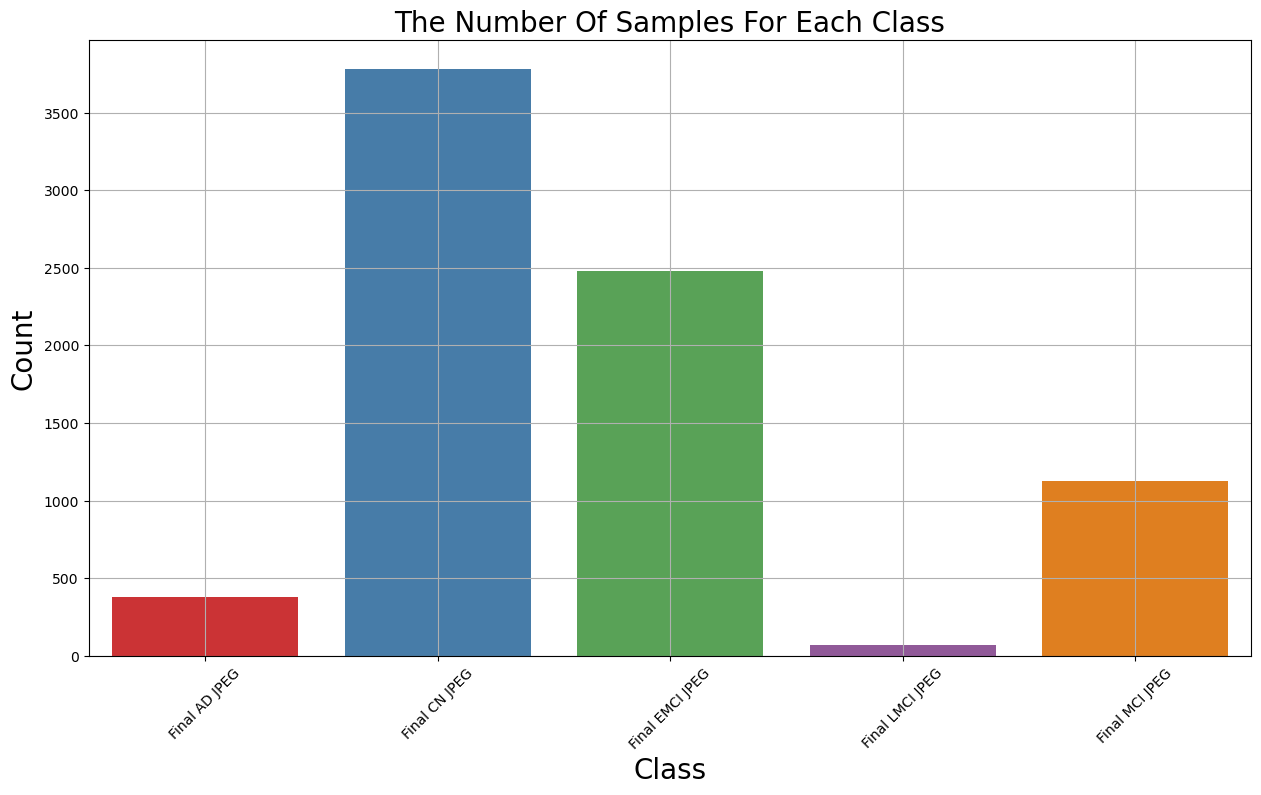

In [26]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

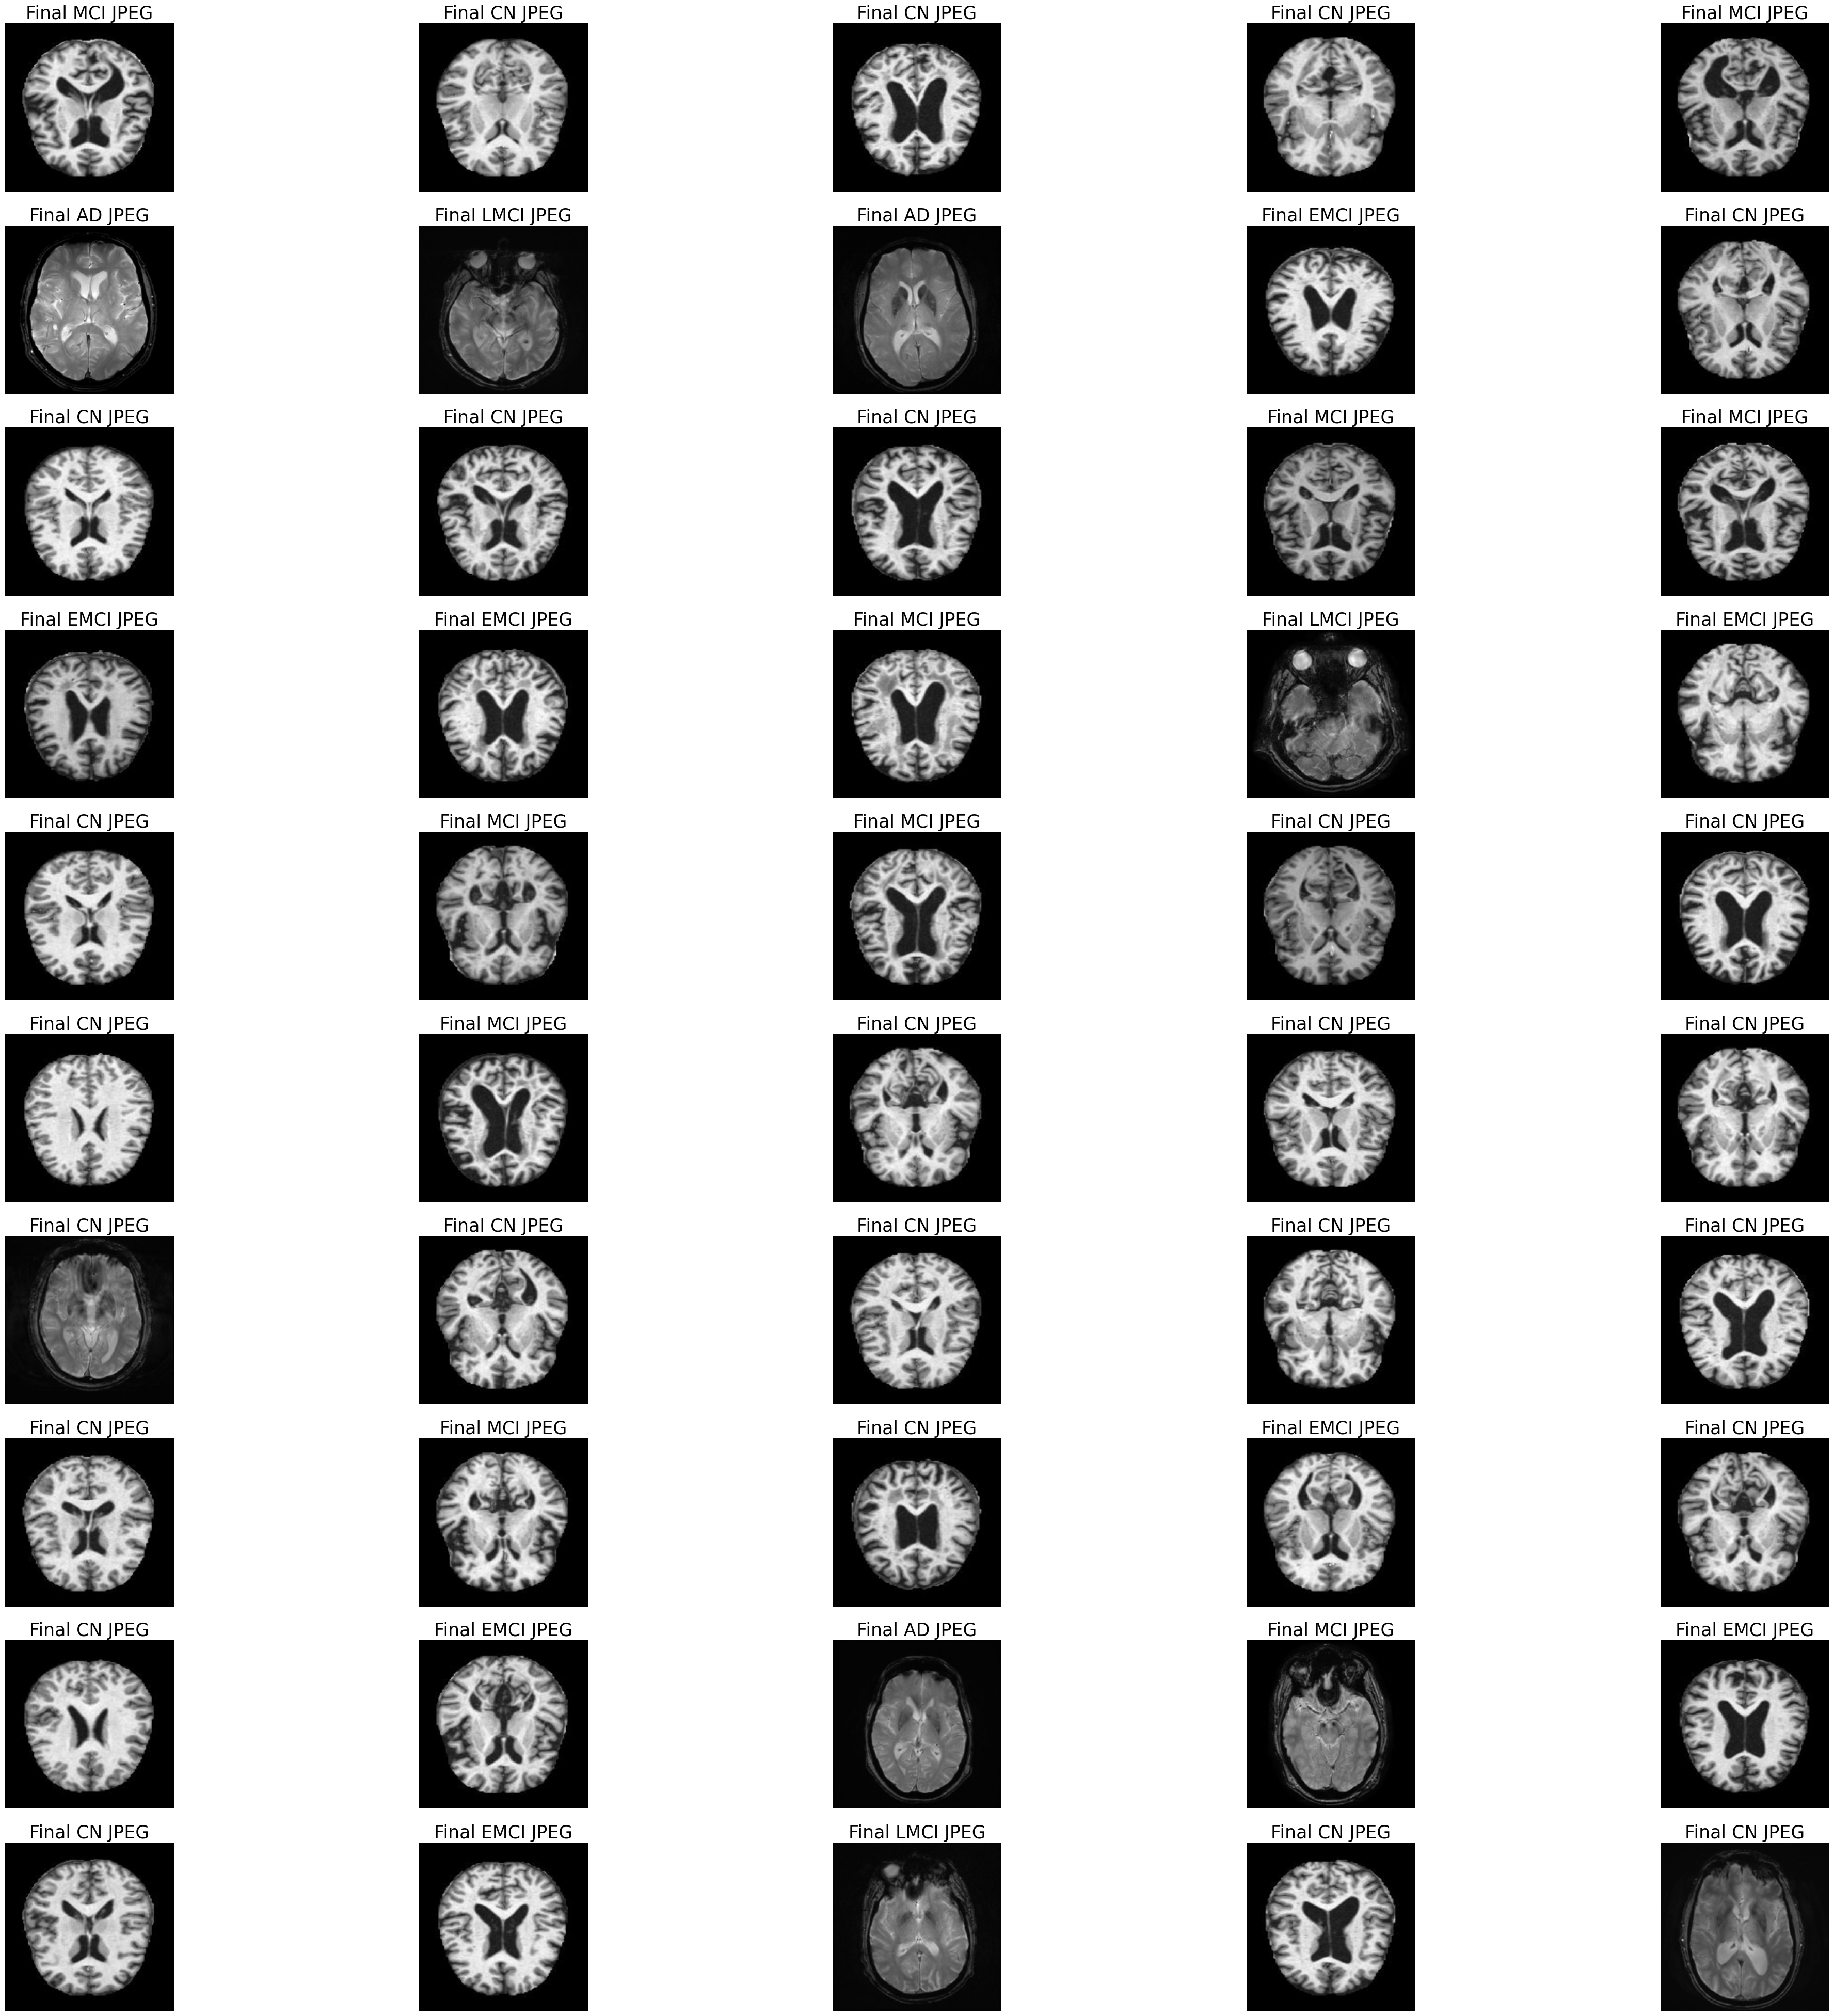

In [27]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

In [50]:
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=1500, shuffle=False)

Found 7841 validated image filenames belonging to 5 classes.


In [51]:
train_data, train_labels = train_data_gen.next()

In [52]:
class_num=np.sort(['Alzheimer_s disease','Cognitively normal','Early mild cognitive impairment','Mild cognitive impairment','Late mild cognitive impairment'])
class_num

array(['Alzheimer_s disease', 'Cognitively normal',
       'Early mild cognitive impairment',
       'Late mild cognitive impairment', 'Mild cognitive impairment'],
      dtype='<U31')

In [53]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1,176,176, 3)
print(train_data.shape, train_labels.shape)

(5190, 176, 176, 3) (5190, 5)


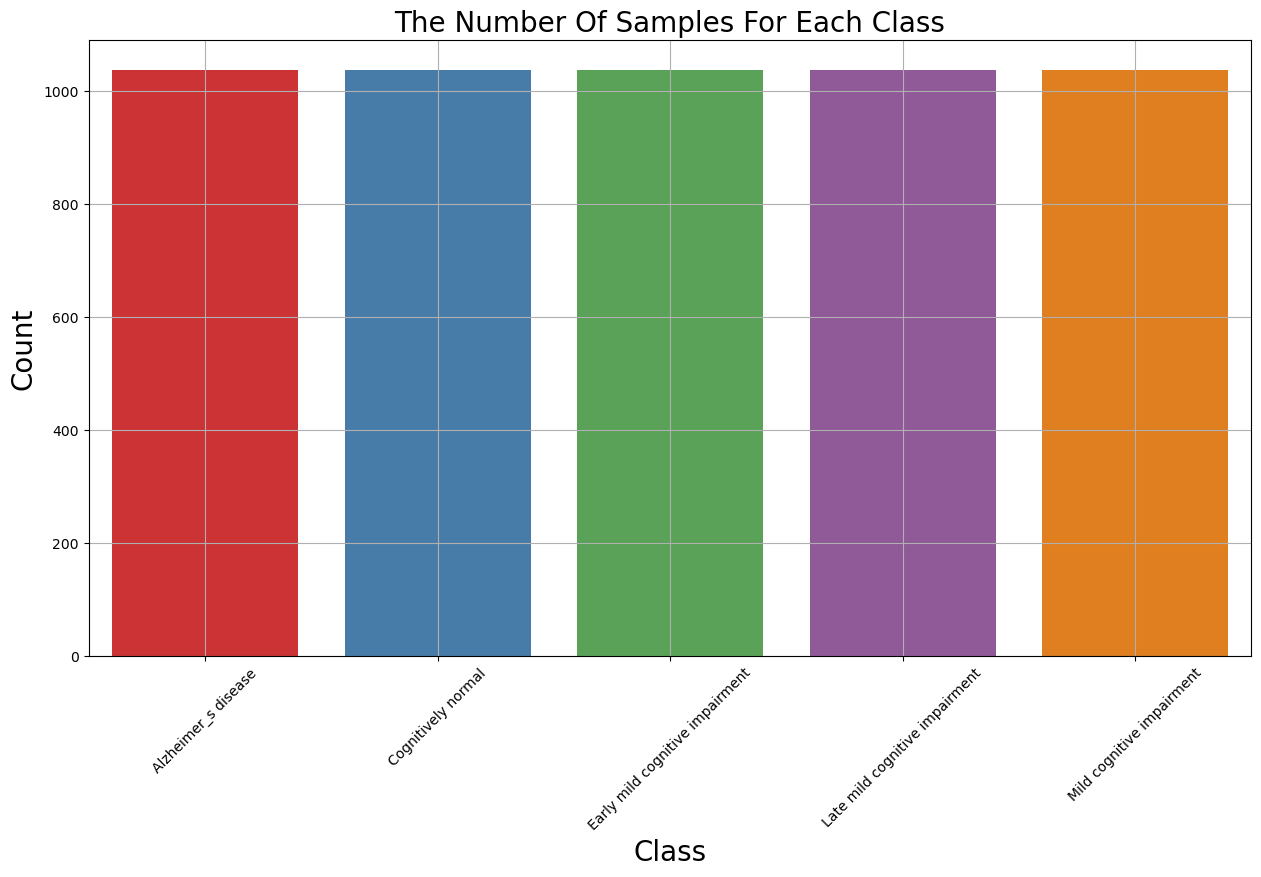

In [54]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(15,8))
ax = sns.countplot(x=labels,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [55]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (3633, 176, 176, 3)
X_test shape is  (779, 176, 176, 3)
X_val shape is  (778, 176, 176, 3)
y_train shape is  (3633, 5)
y_test shape is  (779, 5)
y_val shape is  (778, 5)


In [56]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32,kernel_size=(3,3),strides=2,padding='same',activation='relu',input_shape=(176,176,3)))
model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'))
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Conv2D(128,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024,activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(5,activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 88, 88, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 44, 44, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 11, 11, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 6, 6, 128)         73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 3, 3, 128)        

In [57]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [58]:
checkpoint_cb =ModelCheckpoint("CNN_model.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train,y_train, epochs=50, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
114/114 [==============================] - 12s 85ms/step - loss: 1.1286 - accuracy: 0.5279 - val_loss: 0.5574 - val_accuracy: 0.7841
Epoch 2/50
114/114 [==============================] - 8s 68ms/step - loss: 0.3926 - accuracy: 0.8549 - val_loss: 0.2883 - val_accuracy: 0.8972
Epoch 3/50
114/114 [==============================] - 8s 66ms/step - loss: 0.2068 - accuracy: 0.9251 - val_loss: 0.1691 - val_accuracy: 0.9370
Epoch 4/50
114/114 [==============================] - 7s 65ms/step - loss: 0.1273 - accuracy: 0.9466 - val_loss: 0.1336 - val_accuracy: 0.9499
Epoch 5/50
114/114 [==============================] - 8s 66ms/step - loss: 0.0789 - accuracy: 0.9705 - val_loss: 0.1247 - val_accuracy: 0.9524
Epoch 6/50
114/114 [==============================] - 8s 67ms/step - loss: 0.0511 - accuracy: 0.9818 - val_loss: 0.1067 - val_accuracy: 0.9627
Epoch 7/50
114/114 [==============================] - 8s 68ms/step - loss: 0.0408 - accuracy: 0.9871 - val_loss: 0.0877 - val_accuracy: 0.973

In [59]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0   1.128621  0.527938  0.557366      0.784062
1   0.392578  0.854941  0.288251      0.897172
2   0.206819  0.925131  0.169077      0.937018
3   0.127349  0.946601  0.133637      0.949871
4   0.078929  0.970548  0.124661      0.952442
5   0.051128  0.981833  0.106750      0.962725
6   0.040764  0.987063  0.087691      0.973008
7   0.078735  0.976328  0.092237      0.965296
8   0.012564  0.997247  0.076705      0.978149
9   0.013510  0.995596  0.130409      0.953727
10  0.008291  0.997247  0.072178      0.982005
11  0.038140  0.985962  0.082491      0.979434
12  0.006011  0.998624  0.102672      0.976864
13  0.001975  0.999174  0.071663      0.984576
14  0.001469  0.999725  0.093445      0.980720
15  0.011105  0.996972  0.157579      0.962725
16  0.060159  0.979906  0.141060      0.960154
17  0.013323  0.995321  0.109403      0.975578
18  0.025834  0.993669  0.145520      0.953727
19  0.010263  0.997523  0.077898      0.979434
20  0.000690  1.000000  0.075853      0.982005
21  0.000211  1.000000  0.076877      0.982005
22  0.000126  1.000000  0.079527      0.982005
23  0.000092  1.000000  0.081291      0.982005

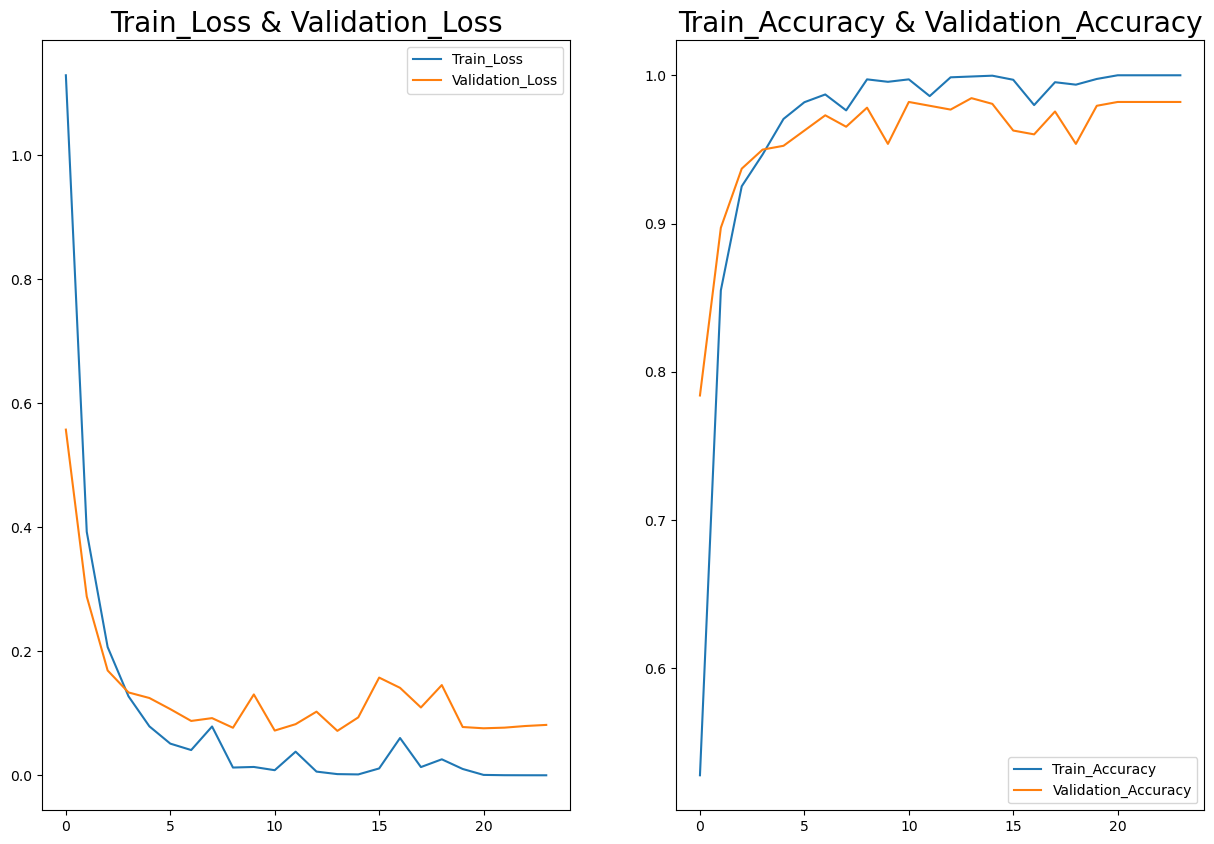

In [60]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [61]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

25/25 [==============================] - 0s 17ms/step - loss: 0.0815 - accuracy: 0.9795
Test Loss = 0.0815437063574791
Test Accuracy = 0.9794608354568481


In [62]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df

25/25 [==============================] - 1s 18ms/step


Actual  Prediction
0         4           4
1         2           2
2         1           1
3         0           0
4         1           1
..      ...         ...
774       1           0
775       0           0
776       2           2
777       4           4
778       3           3

[779 rows x 2 columns]

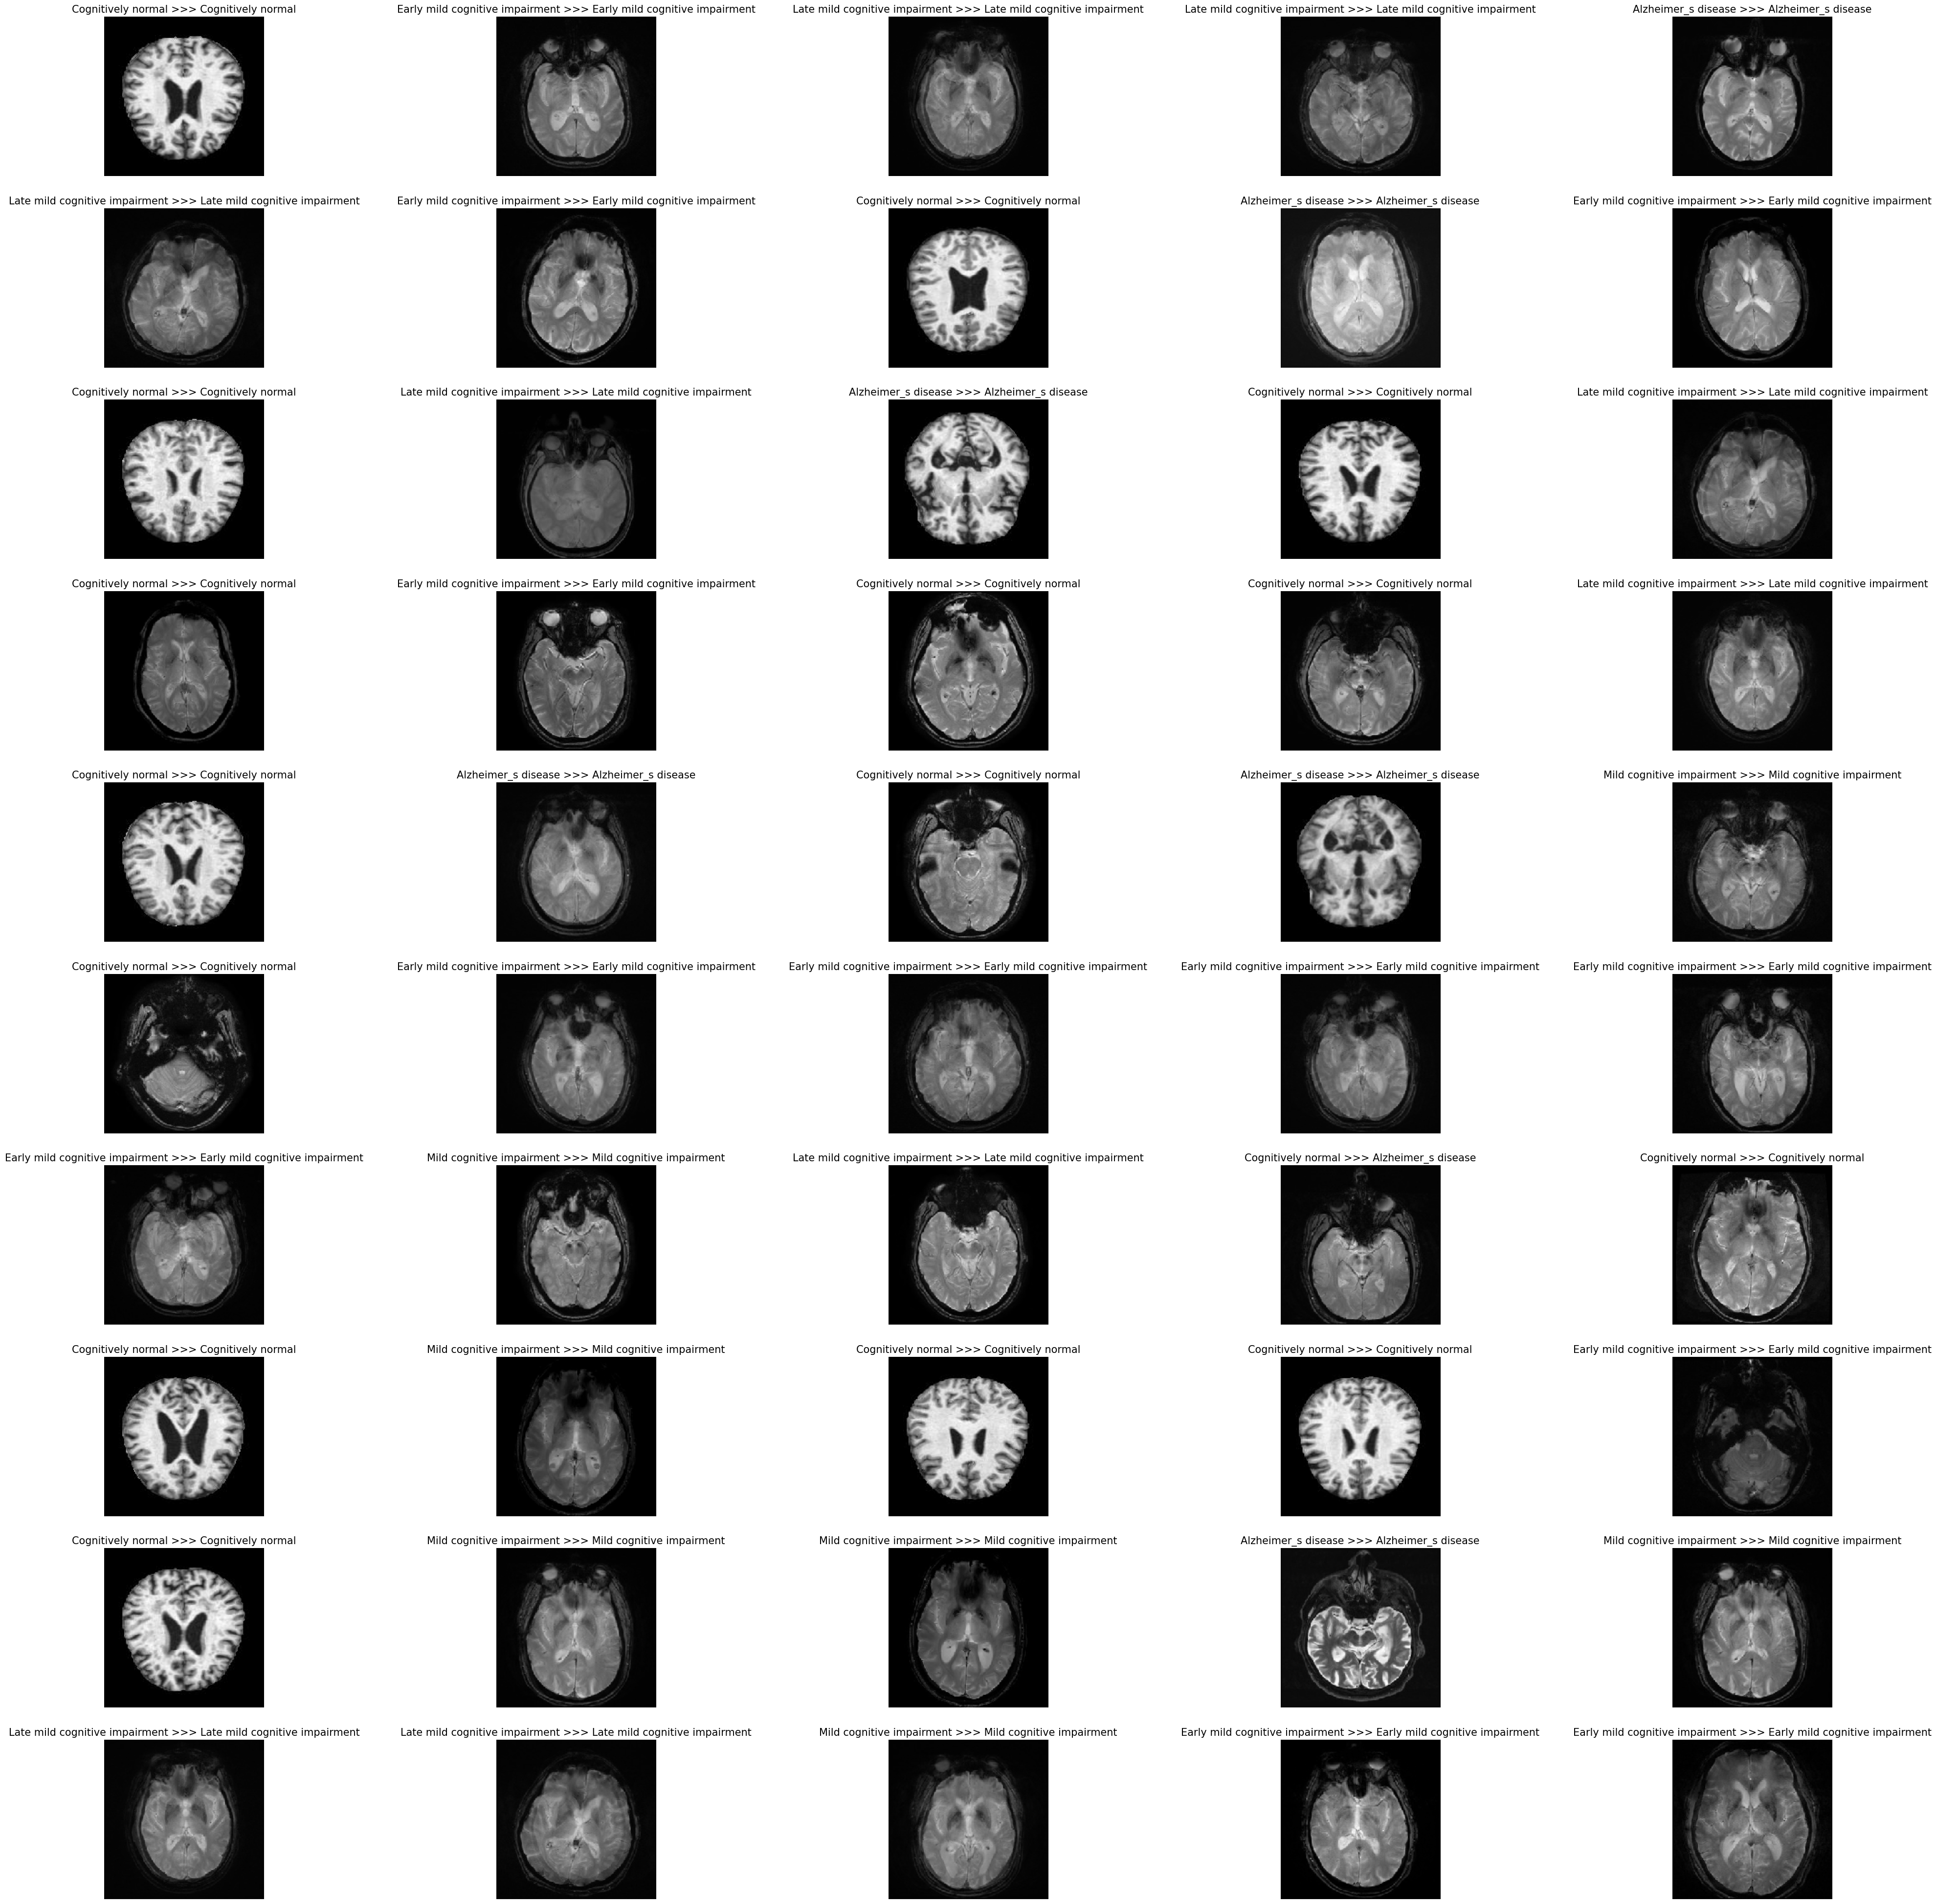

In [63]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(X_test),50)):
    plt.subplot(10,5,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'{class_num[y_test_[i]]} >>> {class_num[y_pred[i]]}',fontsize=15)

array([[153,   2,   1,   0,   0],
       [  8, 143,   3,   1,   1],
       [  0,   0, 155,   0,   0],
       [  0,   0,   0, 156,   0],
       [  0,   0,   0,   0, 156]], dtype=int64)

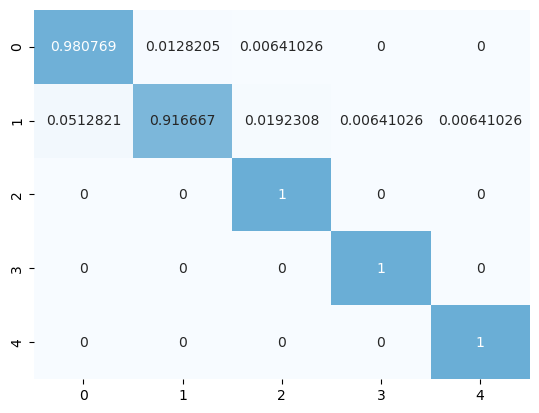

In [64]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [65]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.95      0.98      0.97       156
           1       0.99      0.92      0.95       156
           2       0.97      1.00      0.99       155
           3       0.99      1.00      1.00       156
           4       0.99      1.00      1.00       156

    accuracy                           0.98       779
   macro avg       0.98      0.98      0.98       779
weighted avg       0.98      0.98      0.98       779



In [66]:
from tensorflow.keras.models import load_model
model = load_model(r"C:\Users\khush\Documents\Khushi\4th_Sem\All_India_Woman_Hackathon\CNN_model.keras")

In [67]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
img_path =r"C:\Users\khush\Documents\Khushi\5th_Sem\SolutionsChallengeOther\Alzheimers_dataset\test\Final AD JPEG\ADNI_037_S_4030_MR_AX_T2_STAR_br_raw_20150527140907549_22_S261405_I494761.jpg"
img = image.load_img(img_path, target_size=(176, 176))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

In [68]:
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
print(f'The predicted class is: {predicted_class}')

1/1 [==============================] - 0s 128ms/step
The predicted class is: 0
